In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy import interpolate
from scipy.ndimage import filters, morphology #For minimum finding
import time
from matplotlib.pyplot import cm
import pandas as pd
import h5py

In [3]:
def find_local_minimum(arr):
    """
    Returns the indices corresponding to the local minimum values. Taken 
    directly from https://stackoverflow.com/a/3986876
    
    Parameters
    ----------
    arr : Numpy array
        A D-dimensional array.

    Returns
    -------
    minIndsOut : Tuple of numpy arrays
        D arrays of length k, for k minima found

    """
    neighborhood = morphology.generate_binary_structure(len(arr.shape),1)
    local_min = (filters.minimum_filter(arr, footprint=neighborhood,\
                                        mode="nearest")==arr)
    
    background = (arr==0)
    #Not sure this is necessary - it doesn't seem to do much on the test
        #data I defined.
    eroded_background = morphology.binary_erosion(background,\
                                                  structure=neighborhood,\
                                                  border_value=1)
        
    detected_minima = local_min ^ eroded_background
    allMinInds = np.vstack(local_min.nonzero())
    minIndsOut = tuple([allMinInds[coordIter,:] for \
                        coordIter in range(allMinInds.shape[0])])
    return minIndsOut

def action(path,pot,minimum):
    x_coords = path[:,0]
    y_coords = path[:,1]
    a = 0
    for i in np.arange(0,len(x_coords),1):
        if i== 0:
            pass
        else:
            a += .5*(np.sqrt(2.0*(pot(x_coords[i],y_coords[i]) - minimum)) \
                           + np.sqrt(2.0*(pot(x_coords[i-1],y_coords[i-1])- minimum)))\
                            *np.sqrt(((x_coords[i] - x_coords[i-1]) ** 2 + \
                            (y_coords[i-1] - y_coords[i-1]) ** 2))
    return a

def energy(V,path,minimum):
    total = 0
    for point in path:
        total += V(point[0],point[1]) - minimum
    return(total)
def grad_2d(func,x,y):
    h = 10**(-8)
    ### assumes a 2-dim function f(x,y)
    df_dx = (func(x+h/2,y) - func(x-h/2,y))/h
    df_dy = (func(x,y+h/2) - func(x,y-h/2))/h
    return(df_dx,df_dy)

def eps(V,x,y,m,E_gs):
    result = np.sqrt(2*m*(V(x,y) - E_gs))
    return(result)

### Analytic surfaces
def V_sin(x,y,ax,ay):
    result = ax*np.cos(2.0*np.pi*x) + ay*np.cos(2.0*np.pi*y) 
    return(result)
def Q(r,d,alpha,r0):
    result = 0.5*d*(1.5*np.exp(-2.0*alpha*(r-r0)) - np.exp(-alpha*(r-r0)))
    return(result)
def J(r,d,alpha,r0):
    result = 0.25*d*(np.exp(-2.0*alpha*(r-r0)) - 6.0*np.exp(-alpha*(r-r0)) )
    return(result)
def V_LEPS(rAB,rBC,rAC,a,b,c,dab,dbc,dac,alpha,r0):
    V1 =  Q(rAB,dab,alpha,r0)/(1 + a) + Q(rBC,dbc,alpha,r0)/(1+b) + Q(rAC,dac,alpha,r0)/(1+c)
    V2 = np.sqrt((J(rAB,dab,alpha,r0)/(1+a))**2 + (J(rBC,dbc,alpha,r0)/(1+b))**2 + 
                 (J(rAC,dac,alpha,r0)/(1+c))**2 - J(rAB,dab,alpha,r0)*J(rBC,dbc,alpha,r0)/((1+a)*(1+b)) - 
                 J(rAC,dac,alpha,r0)*J(rBC,dbc,alpha,r0)/((1+b)*(1+c)) 
                 - J(rAB,dab,alpha,r0)*J(rAC,dac,alpha,r0)/((1+a)*(1+c)) )
    V = V1 - V2
    return(V)
def V_HO_LEPS(rAB,x):
    rAC = 3.742
    a = .05
    b = .80
    c = .05
    dab = 4.746
    dbc = 4.746
    dac = 3.445
    r0 = 0.742
    alpha = 1.942
    kc = .2025
    c2 = 1.154
    V1 = V_LEPS(rAB,rAC-rAB,rAC,a,b,c,dab,dbc,dac,alpha,r0)
    V2 = 2.0*kc*(rAB - (0.5*rAC - x/c2))**2
    result = V1 + V2 
    return(result)
def make_time_plot(iters,times,N,M,k,dt,savefig=False):
        plt.plot(iters,times,'.-')
        plt.xlabel('Iterations')
        plt.ylabel('Time (seconds)')
        plt.title('N= '+str(N)+' k= '+str(k)+' dt= '+str(dt)+' Walltime')
        if savefig is not False:
            plt.savefig('Walltime_'+str(M)+'_N_'+str(N)+'_k_'+str(k)+'_dt_'+str(dt)+'.pdf')
        else:pass
        plt.show()
        plt.clf()    

In [5]:
class NEB():
    def __init__(self,f,M,N,x_lims,y_lims,grid_size,R0,RN):
        self.f = f
        self.N = N
        self.M = M
        self.x_lims = x_lims 
        self.y_lims = y_lims 
        self.grid_size = grid_size
        self.x = np.linspace(x_lims[0], x_lims[1], grid_size[0])
        self.y = np.linspace(y_lims[0], y_lims[1], grid_size[1])
        self.xx0,self.yy0 = R0[0],R0[1]
        self.xx1,self.yy1 = RN[0],RN[1]
        self.E_gs = min(self.V(self.xx0,self.yy0),self.V(self.xx1,self.yy1)) #-1.390795954750535
        self.E_const =max(self.V(self.xx0,self.yy0),self.V(self.xx1,self.yy1))
        print('E_gs ',self.E_gs,'E_const',self.E_const)
    def V(self,x,y):
        if isinstance(x, np.ndarray) and isinstance(y, np.ndarray):
            
            assert len(x) == len(y)
            result = np.zeros(len(x))
            for i in range(len(x)):    
                result[i] = f(x[i],y[i]).item()
        else:
            result = f(x,y).item()
        return(result)
    def get_minima(self):
        return(f(self.xx0,self.yy0),f(self.xx1,self.yy1))
    def get_init_path(self):
        ## returns the initial positions of every point on the chain.
        x_coords = np.linspace(self.xx0,self.xx1,self.N)
        y_coords = np.linspace(self.yy0,self.yy1,self.N)
        path = np.stack((x_coords,y_coords),axis=1)
        return(path)
    def get_tang_vect(self,path):
        #returns array of tangen vectors for each point on the chain. The position of each is given by chain coords. 
        #each row is the ith tangent vector directional information. 
        tan_vects = np.zeros(path.shape)
        for i in np.arange(0,len(path),1):
            if i==0:
                tan = (path[i+1] - path[i])
            else:
                if i==len(path)-1:
                    tan = (path[i] - path[i-1])
                else:
                    Vip1 = self.V(path[i+1][0],path[i+1][1])
                    Vi = self.V(path[i][0],path[i][1])
                    Vim1 =self.V(path[i-1][0],path[i-1][1])
                    if (Vip1 > Vi) and (Vi > Vim1): 
                        tan = path[i+1] - path[i]
                    elif (Vip1 < Vi) and (Vi < Vim1): 
                        tan = path[i] - path[i-1]
                    elif (Vip1 < Vi) and (Vi > Vim1) or (Vip1 > Vi) and (Vi < Vim1): 
                        delta_V_min = min(abs(Vip1 - Vi),abs(Vim1 - Vi))
                        delta_V_max = max(abs(Vip1 - Vi),abs(Vim1 - Vi))
                        if Vip1 > Vim1:
                            tan = (path[i+1] - path[i])*delta_V_max + (path[i] - path[i-1])*delta_V_min
                        else: 
                            tan = (path[i+1] - path[i])*delta_V_min + (path[i] - path[i-1])*delta_V_max
                    else:pass
            norm = np.linalg.norm(tan)
            tan = tan/norm
            tan_vects[i] = tan
        tan_vects = np.array(tan_vects)
        return(tan_vects)
    def F_s(self,k,R,tan_vects):
        #returns 2d-array calculating force at each image.
        # R is an array of the position vectors on the chain. each ith row is assumed to be R_{i}
        force = []
        for i in np.arange(0,len(R),1):
            if i==0:
                force.append(np.zeros((1,2))[0])
            else:
                if i==len(R)-1:
                    force.append(np.zeros((1,2))[0])
                else:
                    result = k*(np.linalg.norm(R[i+1] - R[i]) - np.linalg.norm(R[i]  - R[i-1]))*tan_vects[i]
                    force.append(result)
        force = np.array(force)
        return(force)
    def F_r_finite(self,R,tan,params):
        ## gives the "real" force on each image
        force = []
        for i in np.arange(0,len(R),1):
            if i==0:
                force.append(np.zeros((1,2))[0])
            else:
                if i==len(R)-1:
                    force.append(np.zeros((1,2))[0])
                else:
                    grad_Vx,grad_Vy = grad_2d(self.V,R[i][0],R[i][1])
                    
                    grad_V = np.array((grad_Vx,grad_Vy))
                    result = -grad_V + np.dot(grad_V,tan[i])*tan[i]
                    force.append(result)
        force = np.array(force)    
        return(force)
    def g_perp(self,path,tau,params):
        m = params['m']
        E_const = params['E_const']
        k = params['k']
        kappa = params['kappa']
        fix_r0 = params['fix_r0']
        fix_rn = params['fix_rn']
        N_idx = np.arange(0,len(path),1)
        g_perp= np.zeros((len(N_idx),2))
        E = eps(self.V,path[:,0],path[:,1],m,self.E_gs)
        for i in N_idx:
            if i==0:
                if fix_r0 is not False:
                    g_perp[i] = np.zeros((1,2))[0]
                else:
                    g_spr_0 = k*(path[i+1]-path[i])
                    f = -1.0*np.array(grad_2d(self.V,path[i][0],path[i][1]))
                    f_norm = np.linalg.norm(f)
                    g_perp[i] = -1.0*(g_spr_0 - (np.dot(g_spr_0,f/f_norm) - kappa*(self.V(path[i][0],path[i][1]) - E_const))*f/f_norm)
            elif i==len(N_idx)-1:
                if fix_rn is not False:
                    g_perp[i] = np.zeros((1,2))[0]
                else:
                    g_spr_0 = k*(path[i]-path[i-1])
                    f = -1.0*np.array(grad_2d(self.V,path[i][0],path[i][1]))
                    f_norm = np.linalg.norm(f)
                    g_perp[i] = -1.0*(g_spr_0 - (np.dot(g_spr_0,f/f_norm) - kappa*(self.V(path[i][0],path[i][1]) - E_const))*f/f_norm)
            else:
                f = -1*np.array(grad_2d(self.V,path[i][0],path[i][1]))
                d_i = np.linalg.norm(path[i] - path[i-1])
                d_ip1 = np.linalg.norm(path[i+1] - path[i])
                d_ivec = (path[i] - path[i-1])/d_i
                d_ip1vec = (path[i+1] - path[i])/d_ip1
                g_i =.5*((m/E[i])*(d_i + d_ip1)*f - (E[i] + E[i-1])*d_ivec + (E[i+1] + E[i])*d_ip1vec) 
                g_perp[i] = g_i - np.dot(g_i,tau[i])*tau[i]
        return(g_perp) 
    
    def get_forces(self):
        functions = {
            'MEP': self.F_r_finite,
            'LAP': self.g_perp
            }
        return(functions)
    
    def QMV(self,init_path,dt,eta,force_params,target='LAP'):
        ### minimize target function using Quick min Verlet algo
        ### This algo seems much more stable than BFGS.
        ### Initialize the initial path. R0 is the starting point on V and RN is the end point
        action_array = np.zeros((M))
        energies = np.zeros((M))
        ### Initialize the path array
        path = np.full((M,N,2),init_path)
        ### Initialize the velocities, masses, and shift arrays for the QM Verlet Algorithm 
        v = np.full((M,N,2),np.zeros(init_path.shape))
        vp = np.full((M,N,2),np.zeros(init_path.shape))
        a = np.full((M,N,2),np.zeros(init_path.shape))
        mass = np.full(init_path.shape[0],1)
        shift = np.full((M,N,2),np.zeros(init_path.shape))
        start = time.time()
        ### define force function
        force = self.get_forces()[target]
        k = force_params['k']
        #### MAIN KERNEL (QM Verlet)
        for i in np.arange(0,M,1):
            ## calculate the new tangent vectors and forces after each shift.
            tau = self.get_tang_vect(path[i])
            F_spring = self.F_s(k,path[i],tau)
            #g = self.g_perp(path[i],1.0,tau,E_const,k,kappa,fix_r0,fix_rn)
            g = force(path[i],tau,force_params)
            F =  F_spring + g
            for j in np.arange(0,N,1):
                if i==0:
                    vp[i][j]= np.zeros(v[i][j].shape)
                else:
                    if i==M-1:
                        pass
                    else:
                        prod = np.dot(v[i-1][j],F[j])
                        if prod > 0:
                            vp[i][j]= prod*F[j]/np.linalg.norm(F[j])
                        else:
                            vp[i][j] = np.zeros(v[i][j].shape)
                        a[i][j] = F[j]/mass[j] - v[i][j]*eta/mass[j]
                        v[i][j] = vp[i][j] #+ dt*a[i][j]
                        shift[i][j] = v[i][j]*dt + .5*a[i][j]*dt**2
                        x_img = path[i][j][0] + shift[i][j][0]
                        y_img = path[i][j][1] + shift[i][j][1]
                        if x_img < x_lims[0]:
                            path[i+1][j] = np.array([x_lims[0],path[i][j][1]]) 
                        elif x_img > x_lims[1]:
                            path[i+1][j] = np.array([x_lims[1],path[i][j][1]]) 
                        elif y_img < y_lims[0]:
                            path[i+1][j] = np.array([path[i][j][0],y_lims[0]]) 
                        elif y_img > y_lims[1]:
                            path[i+1][j] = np.array([path[i][j][1],y_lims[1]])
                        else:
                            path[i+1][j] = path[i][j] + shift[i][j]
            action_array[i] = action(path[i],self.V,self.E_gs)
            energies[i] = energy(self.V,path[i],self.E_gs)
        end = time.time()
        total_time = end - start
        return(path[-1],action_array,energies,total_time)
    
    def backtrack(self,Fi,Fim,alpha_0,gamma,N_0):
        eps = 10**(-3)
        FiRMS = 0.0
        FimRMS = 0.0
        alpha = alpha_0
        for row in Fi:
            FiRMS += np.sqrt(np.mean(row**2))
        for row in Fim:
            FimRMS += np.sqrt(np.mean(row**2))
        chk = (FiRMS - FimRMS)/(abs(FiRMS + FimRMS))
        skip = False
        N_back = N_0
        if chk > eps:
            alpha = alpha_0*gamma
            skip = True
            N_back = N_0
        else:
            N_back = N_back - 1
            if N_back < 0:
                N_back = N_0
                if alpha < alpha_0:
                    alpha = alpha_0
                    skip=True
                else:
                    alpha = alpha/gamma
            else: pass
        return(alpha,skip)
    
    def BFGS(self,init_path,alpha,beta,gamma,s_max,force_params,target='LAP'):
        ### Initialize arrays
        action_array = np.zeros((M))
        energies = np.zeros((M))
        path = np.full((M,N,2),init_path)
        F = np.full((M,N,2),np.zeros(init_path.shape))
        sigma = np.full((M,N,2),np.zeros(init_path.shape))
        shift = np.full((M,N,2),np.zeros(init_path.shape))
        y =  np.full((M,N,2),np.zeros(init_path.shape))
        H = np.full((M,N,2,2),np.identity(2))
        rho = np.zeros(M)
        start = time.time()
        k = force_params['k']
        force = self.get_forces()[target]
        
        #### MAIN KERNEL (BFGS)
        for i in np.arange(0,M-1,1):
            tau = self.get_tang_vect(path[i])
            F_spring = self.F_s(k,path[i],tau)
            F_real = self.F_r_finite(path[i],tau)
            g = force(path[i],tau,force_params)

            F[i] =  F_spring + g
            for j in np.arange(0,N,1):
                shift[i][j] = np.matmul(H[i][j],F[i][j])
            shift = s_max*shift
            path[i+1] = path[i] + alpha*shift[i]
            path_hold = path[i].copy()
            F_hold = F[i].copy()
            
            tau = self.get_tang_vect(path[i+1])
            F_spring = self.F_s(k,path[i+1],tau)
            g = force(path[i+1],1.0,tau,force_params)
            F[i+1] =  F_spring + g
            
            alpha,skip = self.backtrack(F[i+1],F[i],alpha,gamma,20)
            if skip == True:
                for j in np.arange(0,N,1):
                    H[i][j] = np.identity(2)
                path[i] = path_hold
                F[i] = F_hold
                i = i - 1
            else:
                sigma[i] = path[i+1] - path[i]
                y[i] = -F[i+1] + F[i]
                factor = 0
                for j in np.arange(0,N,1):
                    factor += np.dot(y[i][j],sigma[i][j])
                rho[i] = factor 
                for j in np.arange(0,N,1):
                    if (np.array_equal(H[i][j],np.identity(2))==True):
                        norm = np.dot(y[i][j],y[i][j])
                        if norm != 0:
                            H[i][j] = 1.0/(rho[i]*norm)*np.identity(2)
                        else: pass
                    else:pass
                for j in np.arange(0,N,1):
                    A = np.identity(2) - np.outer(sigma[i][j],y[i][j])*rho[i]
                    B = np.identity(2) - np.outer(y[i][j],sigma[i][j])*rho[i]
                    mat_mul1 = np.matmul(H[i][j],B)
                    H[i+1][j] = np.matmul(A,mat_mul1) + np.outer(sigma[i][j],sigma[i][j])*rho[i]
            
            action_array[i] = action(path[i],self.V,self.E_gs)
            energies[i] = energy(self.V,path[i],self.E_gs)
        end = time.time()
        total_time = end - start
        return(path[-1],action_array,energies,total_time)
    def make_convergence_plot(self,diffs,images,iter_steps,k,dt,savefig=False):
        fig, ax = plt.subplots(2,figsize = (12, 10))
        for i,diff in enumerate(diffs):
            ax[0].plot(images,diff[:,0],'.-',label='x '+str(iter_steps[i+1])+'-'+str(iter_steps[i]))
        ax[0].set_title('x',fontsize=14)
        ax[0].legend(bbox_to_anchor=(1, 1), loc='upper left')
        #ax[0].set_xlabel('Image Label',fontsize=13)
        ax[0].set_ylabel(r'$|R_{i}- R_{i-1}|$',fontsize=13)
        ax[0].set_xticks(images)
        for i,diff in enumerate(diffs):
            ax[1].plot(images,diff[:,1],'.-',label='y '+str(iter_steps[i+1])+'-'+str(iter_steps[i]))
        ax[1].set_title('y',fontsize=14)
        ax[1].legend(bbox_to_anchor=(1, 1), loc='upper left')
        ax[1].set_xlabel('Image Label',fontsize=13)
        ax[1].set_ylabel(r'$|R_{i}- R_{i-1}|$',fontsize=13)
        ax[1].set_xticks(images)
        fig.suptitle('N= '+str(self.N)+' k= '+str(k)+' dt= '+str(dt)+' Convergence', fontsize=16)
        if savefig is not False:
            plt.savefig('x-ycon_M_'+str(self.M)+'_N_'+str(self.N)+'_k_'+str(k)+'_dt_'+str(dt)+'.pdf')
        else: pass
        plt.show()
    
    def make_cplot(self,init_path,pathes,k,grid,zz,savefig=False):
        color=iter(cm.rainbow(np.linspace(0,1,len(pathes))))
        fig, ax = plt.subplots(1,1,figsize = (12, 10))
        im = ax.contourf(grid[0],grid[1],zz,cmap='Spectral_r',levels=MaxNLocator(nbins = 200).tick_values(-2,20))
        ax.contour(grid[0],grid[1],zz,colors=['black'],levels=[0])              
        #ax.plot(init_path[:, 0], init_path[:, 1], '.-', color = 'orange',ms=10)
        for path in pathes:
            c=next(color)
            ax.plot(path[:, 0], path[:, 1], '.-', color = c,ms=10)
            
        ax.set_ylabel('$Q_{30}$',size=20)
        ax.set_xlabel('$Q_{20}$',size=20)
        ax.set_title('M = '+str(self.M)+' N = '+str(self.N)+' k='+str(k))
        cbar = fig.colorbar(im)
        if savefig is not False:
            plt.savefig('Finalpath_M_'+str(self.M)+'_N_'+str(self.N)+'_k_'+str(k)+'.pdf')
        else:pass
        plt.show()  
    def write_path(self,path,fname):
        np.savetxt(fname,path,delimiter='\t')
        return()

E_gs  -0.9713904947341578 E_const -0.001956626031662907


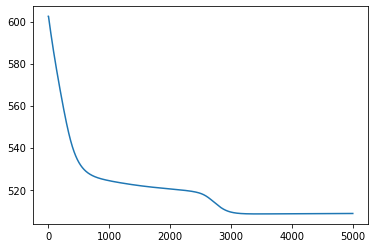

E_gs  -0.9713904947341578 E_const -0.03414321597556711


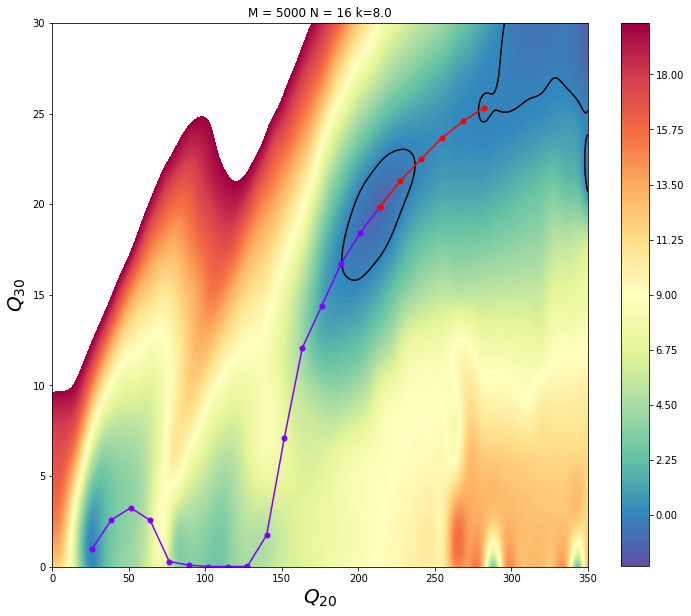

In [6]:
### Define surface here
data_path = '../252U_Test_Case/252U_PES.h5'   
data = h5py.File(data_path, 'r')
Q20_grid = np.array(data['Q20'])
Q30_grid = np.array(data['Q30'])
V_grid = np.array(data['PES'])

'''
fig, ax = plt.subplots()
ax.contourf(xx,yy,zz,levels=MaxNLocator(nbins = 200).tick_values(-2,20))
ccp = ax.contour(xx,yy,zz,levels=[0])
turning_line= max(ccp.allsegs[0], key=len)
'''
### interpolate the grid
nx = 500 # number of points on x-axis
ny = 500 # number of points on y-axis
Q20 = np.linspace(Q20_grid[:,0][0],Q20_grid[:,0][-1],nx)
Q30 = np.linspace(Q30_grid[0][0],Q30_grid[0][-1],ny)

xx, yy = np.meshgrid(Q20,Q30)

### create interpolation function
f = interpolate.RectBivariateSpline(Q20_grid[:,1], Q30_grid[0], V_grid, kx=5, ky=5, s=0)

zz = f(Q20,Q30).T
minima_ind = find_local_minimum(zz)
local_minima = zz[minima_ind]
order = np.argsort(local_minima)
ordered_minima = local_minima[order]
x_minima,y_minima = xx[minima_ind],yy[minima_ind]
x_minima,y_minima = x_minima[order],y_minima[order]

N = 16
M = 5000
dt = .1


x_lims = (Q20[0],Q20[-1])
y_lims = (Q30[0],Q30[-1])
grid_size = V_grid.shape
eta = 1.0
alpha = 1.0
beta = 1.0
gamma = 0.5
s_max = .1
R0 = (25.95,0.96) # start at GS
RN = (213.92,19.83) # end at first minimum 

band =  NEB(f,M,N,x_lims,y_lims,grid_size,R0,RN)
init_path = band.get_init_path()
minima = band.get_minima()

E_const = 0
m = 1.0
k = 8.0
kappa = 1.0
fix_r0=True
fix_rn=True

force_params= {'E_const':E_const,'m':m,'k':k,'kappa':kappa,'fix_r0':fix_r0,'fix_rn':fix_rn}
path_QMV,action_array_QMV,energies_QMV,total_time_QMV = band.QMV(init_path,dt,eta,force_params,target='LAP')

   

plt.plot(np.arange(len(action_array_QMV)),action_array_QMV)
plt.show()
R0 = path_QMV[-1] ## start second band at first band ending
RN = (281.96,25.31) ## end at final otp
### TODO: add otp finder from ML code
N = 6
band2 =  NEB(f,M,N,x_lims,y_lims,grid_size,R0,RN)
init_path =  band2.get_init_path()
path_QMV2,action_array_QMV2,energies_QMV2,total_time_QMV2 = band2.QMV(init_path,dt,eta,force_params,target='LAP')

band.make_cplot(init_path,[path_QMV,path_QMV2],k,[xx,yy],zz,savefig=False)